In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)
c = context

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.01, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
unique_genres = set(genre[-1] for genre in genres)
len(unique_genres)

72

In [9]:
x_train.shape

(500, 160, 10, 1)

In [10]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres)

In [11]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [12]:
latent_dim = 10
epsilon_std = 1.0
batch_size = 128
epochs = 500

name = 'non-functional_model.h5'
fn = config.model_dir + name

In [13]:
vae, encoder, generator = models.build(input_shape, latent_dim)
vae.load_weights(fn)

/usr/local/lib/python3.6/site-packages/keras/layers/core.py:642: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `[(None, 10), (None, 10)]` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/Users/mark/src/pattern-recognition/src/models.py:147: UserWarning: Output "decoder_model-" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder_model-" during training.
  vae.compile(optimizer='adam')


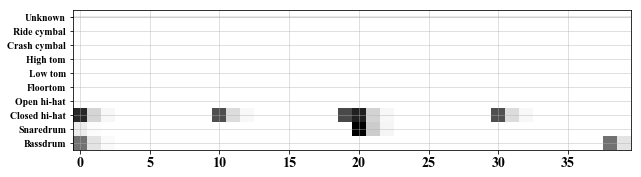

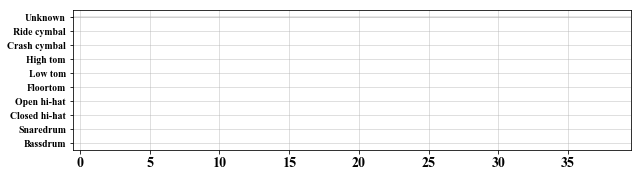

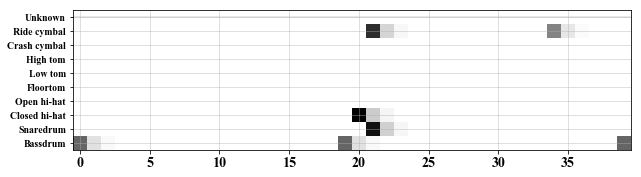

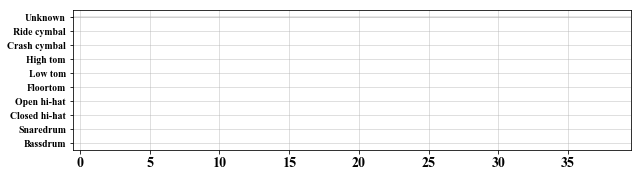

In [14]:
# utils.reload(plot)
i,j = 0, 10
m = 40
y = midi.decode.identity(c, vae.predict(x_train[:50]))
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

## Style transfer

In [15]:
m = 500
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(500, 10)

In [16]:
x_train.shape

(500, 160, 10, 1)

In [17]:
fn = config.plots_dir + 'transformations-best_dims.pkl'
best_dims = io.load(fn)
fn = config.plots_dir + 'transformations.pkl'
transformations = io.load(fn)
fn = config.plots_dir + 'min_transformations.pkl'
min_transformations = io.load(fn)

In [18]:
list(transformations.keys())[:]

['04 Country/01 Calvin 148BPM',
 "01 Rock'n'Roll/07 Thwag 170BPM",
 '03 Traditional Pop/07 Lester Lee 133BPM',
 "01 Rock'n'Roll/08 Doowoop 140bpm",
 '07 Indie/08 Bouncer 162BPM',
 "01 Rock'n'Roll/10 Ottis 172bpm",
 '07 Indie/01 Rock Shuffle 130BPM',
 '03 Traditional Pop/01 Fly High 115BPM',
 '03 Traditional Pop/10 Frewild 152BPM',
 '07 Indie/06 Swing Funk 102BPM',
 '05 Jazz/02 Another You 170BPM',
 '06 Soul - Funk/10 Syncopated Ride 128BPM',
 '07 Indie/09 Slow Shuffle 80BPM',
 '06 Soul - Funk/03 Cadence Soul 105BPM',
 '05 Jazz/04 Silent Tear 234BPM',
 "01 Rock'n'Roll/05 Straight Line 136BPM",
 '03 Traditional Pop/08 Cecil Cee 101BPM',
 '06 Soul - Funk/09 Smooth Soul 81BPM',
 '04 Country/08 Eddie Ed 111BPM',
 '07 Indie/11 Disco Dancer 135BPM',
 "01 Rock'n'Roll/03 Lips n Hips 152BPM",
 '06 Soul - Funk/02 Boogaloo 120BPM',
 '02 Blues/01 Booze 92BPM',
 '06 Soul - Funk/07 Ride Swing 95Bpm',
 "01 Rock'n'Roll/09 Diddeley 185bpm",
 "01 Rock'n'Roll/01 Dancin Rick 166BPM",
 '03 Traditional Pop/0

In [19]:
len(transformations.keys())

71

In [20]:
# select n random transformations
def choose_transformations(transformations, n=20, randomize=False, scale=2):
    t_chosen = collections.defaultdict(dict)
    k_a = np.random.choice(list(transformations.keys()), n)
    for genre_a in k_a:
        genre_b = np.random.choice(list(transformations[genre_a].keys()))
        if randomize:
            v = np.zeros_like(transformations[genre_a][genre_b])
#             v[np.random.randint(0,v.shape[0])] = 0.001
            v = np.random.random(v.shape[0])
            t_chosen[genre_a][genre_b] = v
        else:
            v = transformations[genre_a][genre_b] * scale
            if max(v) > 0:
                v = np.clip(v, 0.2, 0.5)
                print(max(v))
            else:
                v = np.clip(v, -0.5, 0.2)
                print(min(v))
            t_chosen[genre_a][genre_b] = v
    return t_chosen
t_chosen = choose_transformations(min_transformations, randomize=False)

0.5
0.5
0.2748302221298218
0.2
0.2
0.2
-0.5
0.2
-0.5
-0.11356206983327866
-0.035057928413152695
-0.11274313926696777
0.2
0.2
0.2
-0.5
0.5
0.2
-0.03680724650621414
0.2


In [21]:
def choose_samples(genre_dict, transformations):
    genre_dict2 = collections.defaultdict(dict)
    for genre_a in transformations.keys():
        for genre_b in transformations[genre_a].keys():
            samples = transformations[genre_a][genre_b]
            i = np.random.choice(np.arange(samples.shape[0]))
            genre_dict2[genre_a][genre_b] = [i]
    return genre_dict2
genre_dict2 = choose_samples(genre_dict, t_chosen)

In [22]:
utils.reload(ncd_evaluation)
grid = [0, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
grid = np.linspace(0,1,20)
db, x_result, db2, meta = ncd_evaluation.transform(x_train_encoded, genre_dict2, t_chosen, 
                generator, grid, amt1=None, amt2=None, v=1)

06 Soul - Funk/09 Smooth Soul 81BPM 	-> 06 Soul - Funk/06 JB Groove 115BPM
06 Soul - Funk/03 Cadence Soul 105BPM 	-> 04 Country/07 Trainy 100BPM
01 Rock'n'Roll/06 Moonglow 140BPM 	-> 07 Indie/10 Chilled 120BPM
04 Country/09 Broonze 122BPM 	-> 07 Indie/10 Chilled 120BPM
04 Country/02 Marching 94BPM 	-> 01 Rock'n'Roll/09 Diddeley 185bpm
03 Traditional Pop/01 Fly High 115BPM 	-> 01 Rock'n'Roll/02 Gogo 191BPM
04 Country/03 Straight 72BPM Brushes 	-> 01 Rock'n'Roll/08 Doowoop 140bpm
03 Traditional Pop/06 Bopop 130MPM 	-> 06 Soul - Funk/06 JB Groove 115BPM
03 Traditional Pop/06 Bopop 130MPM 	-> 06 Soul - Funk/03 Cadence Soul 105BPM
03 Traditional Pop/06 Bopop 130MPM 	-> 03 Traditional Pop/04 Love 155BPM
01 Rock'n'Roll/07 Thwag 170BPM 	-> 02 Blues/09 Leroyes 130BPM
03 Traditional Pop/05 Your Eyes 80BPM 	-> 01 Rock'n'Roll/05 Straight Line 136BPM
07 Indie/11 Disco Dancer 135BPM 	-> 01 Rock'n'Roll/02 Gogo 191BPM
02 Blues/08 Sams 127BPM 	-> 01 Rock'n'Roll/06 Moonglow 140BPM
05 Jazz/10 Scalis 190B

In [23]:
# io.save(db, config.results_dir + 'applied_transformations-db.pkl')
# io.save(db2, config.results_dir + 'applied_transformations-db2.pkl')
# io.save(x_result, config.results_dir + 'applied_transformations-x_result.pkl')
# io.save(meta, config.results_dir + 'applied_transformations-meta.pkl')

In [24]:
db = io.load(config.results_dir + 'applied_transformations-db.pkl')
db2 = io.load(config.results_dir + 'applied_transformations-db2.pkl')
x_result = io.load(config.results_dir + 'applied_transformations-x_result.pkl')
meta = io.load(config.results_dir + 'applied_transformations-meta.pkl')

In [25]:
x_result[0][0].shape # (transformation, grid, samples, timesteps, notes, 1)

(1, 160, 10, 1)

In [26]:
len(x_result), len(x_result[0]), x_result[0][0].shape #transformations, grid, n samples

(20, 20, (1, 160, 10, 1))

In [27]:
len(x_result), len(x_result[0])

(20, 20)

In [28]:
# genre_dict

In [29]:
# # utils.reload(plot)
# plot.single(x_result[0,1], figsize=(20,40))
# plot.single(x_result[0,1, :40])

In [30]:
# # utils.reload(midi.decode, midi.encode, midi)
# utils.reload(plot)
# c = context
# k = list(db.keys())[2]
# _,keys,i = utils.get(db[k], recursion_depth=0, i=0)
# x = midi.decode.identity(c, x_result[i])
# print(k, keys)
# print(x.shape)
# # utils.reload(plot)
# for i in range(x.shape[0]):
#     plot.single(x[i,:80], figsize=(12, 8)) # 8, 12

In [31]:
# utils.reload(plot)
# # plot.single(x[0,:40], figsize=(8, 12))
# plot.multi(x, 80, figsize=(30,20), v=1)

In [32]:
io.reset_midis_dir()
# for i in range(5):
for j,d in enumerate(genre_dict2.values()):
    for i_list in d.values():
        i = i_list[0]
        mid = midi.decode.track(context, x_train[i])
        io.export_midifile(mid, config.export_dir + 'test-original-%i'%i, name='test-original-%i'%i)
        mid = midi.decode.track(context, x_result[j][0][0])
        io.export_midifile(mid, config.export_dir + 'test-original-copy-%i'%i, name='test-original-copy-%i'%i)
# plot.single(x_train[i,:80])
# plot.single(x_result[j][0][0][:80])

In [33]:
utils.reload(midi, io)
def save_sample_grid(x, i, grid_i, grid, v=0):
    value = grid[grid_i]
    name = 'incr-transform'
    suffix = name + ('{id-%i-%i-%s}'%(i, grid_i, str(round(value,2))))
    fn = config.export_dir + suffix
    if v: print(fn)
    mid = midi.decode.track(context, x, v=0)
    io.export_midifile(mid, fn, name=suffix)

def save_sample(x, i, v=0):
    name = 'incr-transform'
    suffix = name + ('{id-%i}'%i)
    fn = config.export_dir + suffix
    if v: print(fn)
    mid = midi.decode.track(context, x, v=0)
    io.export_midifile(mid, fn, name=suffix)    

In [79]:
# genre_dict2

In [80]:
db2

{0: ('07 Indie/03 Moon 137BPM', '04 Country/02 Marching 94BPM'),
 1: ('07 Indie/03 Moon 137BPM', "01 Rock'n'Roll/04 Maybelline 233BPM"),
 2: ('07 Indie/06 Swing Funk 102BPM', '06 Soul - Funk/09 Smooth Soul 81BPM'),
 3: ('04 Country/03 Straight 72BPM Brushes', '05 Jazz/02 Another You 170BPM'),
 4: ('04 Country/03 Straight 72BPM Brushes', '05 Jazz/05 TNT 116BPM'),
 5: ('05 Jazz/04 Silent Tear 234BPM', '05 Jazz/07 Kooper 234BPM'),
 6: ('04 Country/05 Brewer 160BPM', '03 Traditional Pop/03 King Quiza 102BPM'),
 7: ('04 Country/07 Trainy 100BPM', '02 Blues/10 Bogeart 122BPM'),
 8: ('06 Soul - Funk/10 Syncopated Ride 128BPM',
  '02 Blues/04 Mickeys 212BPM 12-8'),
 9: ('02 Blues/01 Booze 92BPM', '05 Jazz/05 TNT 116BPM'),
 10: ('03 Traditional Pop/08 Cecil Cee 101BPM', '04 Country/01 Calvin 148BPM'),
 11: ("01 Rock'n'Roll/10 Ottis 172bpm",
  '03 Traditional Pop/02 Frankies Girl 116BPM'),
 12: ('03 Traditional Pop/05 Your Eyes 80BPM',
  '05 Jazz/09 West Coast 152BPM Brushes'),
 13: ("01 Rock'n'

In [35]:
# t_chosen  # values lower than 0.01

In [47]:
utils.reload(midi, midi.pitches, midi.decode)
io.reset_midis_dir()
for i, grid_samples in enumerate(x_result):
# for i, k in enumerate(keys):
#     transformation = x_result[k]
    seq = [grid_samples[i][0] for i in range(len(grid_samples))]
#     for i in range(len(grid_samples)):
#         plot.single(grid_samples[i][0][:40])
    seq = midi.concatenate(seq)
    save_sample(seq, i)
#     a = grid_samples[0] - grid_samples[-1]
#     plot.single(a[0][:40], figsize=(3,3))
#     print(np.sum(a), seq.shape)

#     for grid_i, grid_sample in enumerate(grid_samples):
#         for sample in grid_sample:
#             save_sample(sample, i, grid_i, grid)

In [56]:
dn = config.results_dir + 'plots/'
dn

'../results/plots/'

In [257]:
utils.reload(plot, io, midi.decode, midi.encode)
figsize = (30,10)
figsize=(15,10)
# plot.single(x_train[0], figsize=figsize, fn=dn+'2')
def plot_(i=0, grid=[0,2,3,4], prefix='name'):
#     x = np.array([x_result[i][grid_i][0] for grid_i in grid])
#     plot.multi(x, fn=dn+'a')
    for grid_i in grid:
        x = x_result[3][grid_i][0]
        x = midi.decode.identity(c,x)
        print(x.shape)
        print(i,grid_i)
        fn = dn + prefix + '-%i-%i'%(i,grid_i)
#         fn = None
        x = np.array(x[:80])
        plot.single(x, figsize=figsize, fn=fn)

(160, 10)
3 0
n_bars = 2.000000, 	length=80.000000


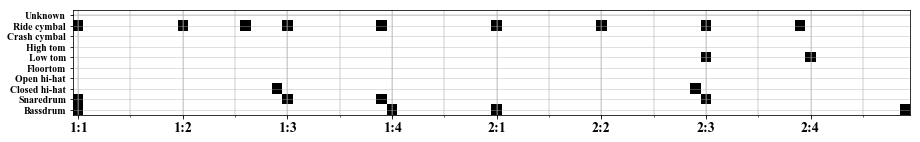

(160, 10)
3 2
n_bars = 2.000000, 	length=80.000000


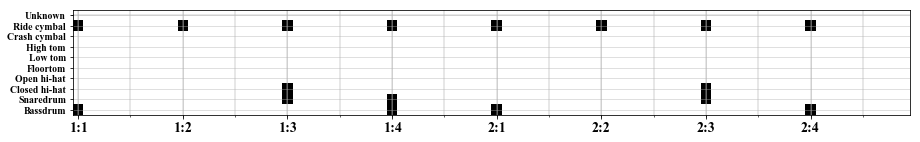

(160, 10)
3 3
n_bars = 2.000000, 	length=80.000000


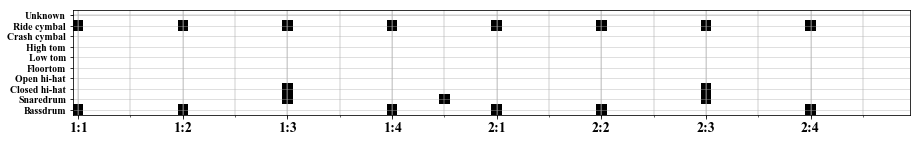

(160, 10)
3 4
n_bars = 2.000000, 	length=80.000000


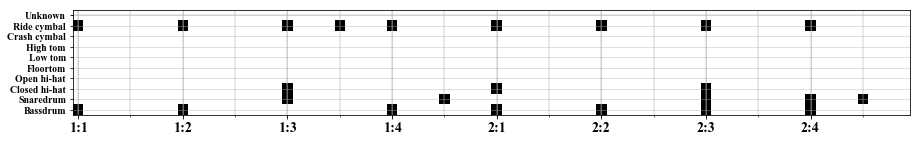

In [258]:
plot_(3, prefix='country-jazz')

(160, 10)
5 0
n_bars = 2.000000, 	length=80.000000


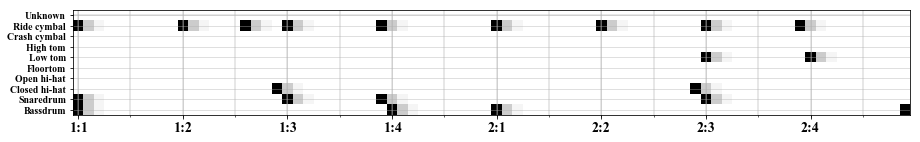

(160, 10)
5 -3
n_bars = 2.000000, 	length=80.000000


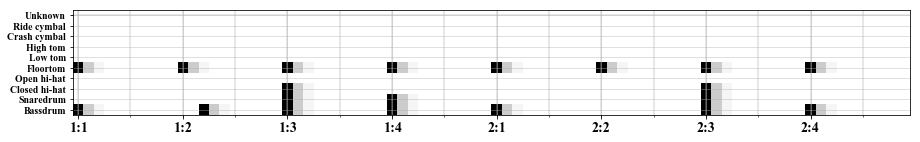

In [256]:
plot_(5, grid=[0,-3], prefix='-')

In [246]:
# x_result[0][0][0].shape

n_bars = 4.000000, 	length=160.000000


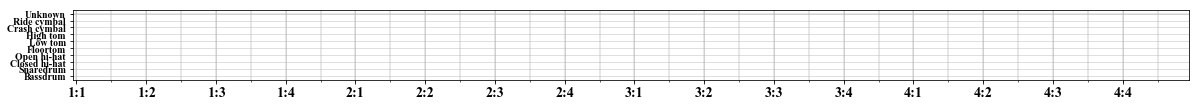

n_bars = 4.000000, 	length=160.000000


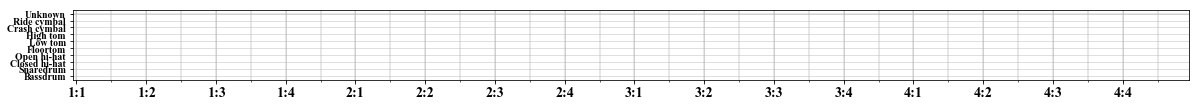

n_bars = 4.000000, 	length=160.000000


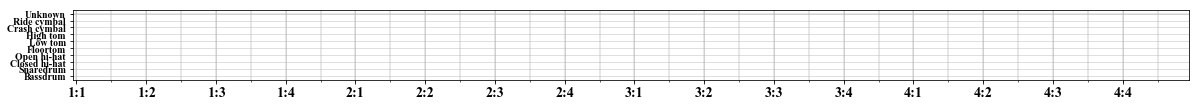

In [42]:
# utils.reload(plot, midi.decode)
for i in [0, 10, -1]:
    plot.single(x_result[0][i][0], figsize=(20,20), transform=context)

In [43]:
labels[0]

"../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"

In [44]:
# utils.reload(midi, midi.encode, midi.decode, plot)
# # x = vae.predict(x_train[:9])
# x = x_train[0]
# x_ = midi.decode.identity(context,x)
# for xx in [x, x_]:
#     print(xx.shape)
#     plot.single(xx[:40])